<a href="https://colab.research.google.com/github/semerriam/census-peculiarities/blob/main/analysis/CO_Identifying_Census_Blocks_Querying_Google_Static_Map_and_Streetview_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Querying the Google Streetview API

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
!pip install geopandas
import geopandas as gpd
import requests
import altair as alt
from time import sleep
import getpass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Necessary imports
import pandas as pd
from plotnine import *

# I don't think we use these?
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [3]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [4]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
%%R

# My commonly used R imports

require('ggplot2')
require('readr')
require('extrafont')
require('dplyr')
require('reshape2')
require('explore')
require('tidyr')
require('forcats')
require('knitr')
require('ragg')
require('palmerpenguins')
# require('theme538')

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: readr

R[write to console]: Loading required package: extrafont

R[write to console]: Loading required package: dplyr

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: reshape2

R[write to console]: Loading required package: explore

R[write to console]: Loading required package: tidyr

R[write to console]: Loading required package: forcats

R[write to console]: Loading required package: knitr

R[write to console]: Loading required package: ragg

R[write to console]: Loading required package: palmerpenguins



In [6]:
df = pd.DataFrame(
    np.random.randint(0,100,size=(100, 2)), columns=list('AB'))
df.head()

,A,B
0,8,25
1,98,62
2,4,7
3,21,78
4,67,65


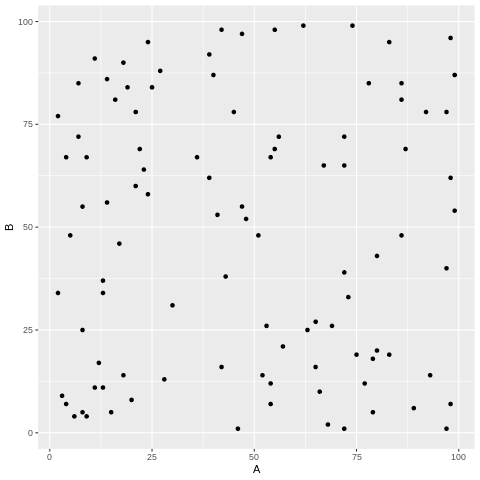

In [7]:
%%R -i df

# EXAMPLE R CELL
df
plt <- ggplot(df) +
    geom_point(aes(A,B))

plt

In [8]:
pd.set_option("display.max_columns", None)

In [9]:
apikey = getpass.getpass()

··········


##### Importing Merged CSV from Output of Census Chaos notebook

In [10]:
url_1 = 'https://github.com/semerriam/census-peculiarities/raw/main/data/processed/merged/output_co_merged.csv'
df_co = pd.read_csv(url_1)

In [11]:
df_co.head(3)

,FILEID,STUSAB,GEOCODE,COUNTY,TRACT,BLKGRP,BLOCK,AREALAND,NAME,INTPTLAT,INTPTLON,P0010001,P0020001,P0030001,P0050001,P0050003,P0050004,GEOID20,county_name,TOTALPOP_ADJ,dif_pop,adjpop
0,PLST,CO,80010078011000,1,7801,1,1000,20912,Block 1000,39.742879,-104.866410,120,120,82,0,0,0,80010078011000,Adams,123,3,123
1,PLST,CO,80010078011001,1,7801,1,1001,20185,Block 1001,39.742879,-104.867597,156,156,120,0,0,0,80010078011001,Adams,156,0,156
2,PLST,CO,80010078011002,1,7801,1,1002,20340,Block 1002,39.742880,-104.868770,234,234,177,0,0,0,80010078011002,Adams,238,4,238


In [12]:
# df_co = pd.read_csv("output_co_merged.csv", encoding="utf-8")
# df_co.head(3)

In [13]:
df_co.shape

(140345, 22)

In [14]:
df_co.query("P0020001 == 0").sort_values(by="dif_pop", ascending = False).head(5)

,FILEID,STUSAB,GEOCODE,COUNTY,TRACT,BLKGRP,BLOCK,AREALAND,NAME,INTPTLAT,INTPTLON,P0010001,P0020001,P0030001,P0050001,P0050003,P0050004,GEOID20,county_name,TOTALPOP_ADJ,dif_pop,adjpop
96915,PLST,CO,80770003001014,77,300,1,1014,17330,Block 1014,39.070859,-108.565311,0,0,0,0,0,0,80770003001014,Mesa,13,13,13
13466,PLST,CO,80050074001008,5,7400,1,1008,20210,Block 1008,39.735571,-104.860573,0,0,0,0,0,0,80050074001008,Arapahoe,10,10,10
11893,PLST,CO,80050068154018,5,6815,4,4018,77230,Block 4018,39.583438,-104.874800,0,0,0,0,0,0,80050068154018,Arapahoe,8,8,8
61196,PLST,CO,80410063021008,41,6302,1,1008,7530,Block 1008,38.818317,-104.753702,0,0,0,0,0,0,80410063021008,El Paso,6,6,6
77166,PLST,CO,80590116012002,59,11601,2,2002,15486,Block 2002,39.725489,-105.069163,0,0,0,0,0,0,80590116012002,Jefferson,6,6,6


#### Importing Table copied from README file with DOC count — Colorado Independent Redistricting Commissions Staff

Source: Memo Incarcerated Persons Adjustments_Aug_6_2021_Legislative_Commission.pdf

In [15]:
url_2 = 'https://raw.githubusercontent.com/semerriam/census-peculiarities/main/data/handmade/readmes/co-readme-incarcerated-persons-adjustments-08-06-2021.csv'
df_co_readme = pd.read_csv(url_2)
df_co_readme

,Facility,County,Total
0,ARKANSAS VALLEY CORRECTIONAL FACILITY,Crowley,"1,059"
1,ARROWHEAD CORRECTIONAL CENTER,Fremont,513
2,BENT COUNTY CORRECTIONAL FACILITY,Bent,"1,382"
3,BUENA VISTA CORRECTIONAL COMPLEX,Chaffee,908
4,BUENA VISTA MINIMUM CENTER,Chaffee,290
5,BUENA VISTA TRANSITIONAL WORK CENTER,Chaffee,10
6,CENTENNIAL CORRECTIONAL FACILITY,Fremont,403
7,COLORADO CORRECTIONAL CENTER (CAMP GEORGE WEST),Jefferson,123
8,COLORADO STATE PENITENTIARY,Fremont,706
9,COLORADO TERRITORIAL CORRECTIONAL FACILITY,Fremont,910


In [16]:
# df_co_readme = pd.read_csv("co-readme-incarcerated-persons-adjustments-08-06-2021.csv", encoding="utf-8")
# df_co_readme

#### Identifying Facilities in Census Blocks 

In [17]:
df_co.query("P0050003 > 0").sort_values(by="P0050003", ascending  = False).head(3)

,FILEID,STUSAB,GEOCODE,COUNTY,TRACT,BLKGRP,BLOCK,AREALAND,NAME,INTPTLAT,INTPTLON,P0010001,P0020001,P0030001,P0050001,P0050003,P0050004,GEOID20,county_name,TOTALPOP_ADJ,dif_pop,adjpop
65245,PLST,CO,80439802001000,43,980200,1,1000,2173673,Block 1000,38.359615,-105.097914,2532,2532,2532,2532,2532,0,80439802001000,Fremont,2532,0,2532
96619,PLST,CO,80759664001238,75,966400,1,1238,631605,Block 1238,40.611755,-103.161651,2436,2436,2436,2436,2436,0,80759664001238,Logan,486,-1950,486
31481,PLST,CO,80259696012045,25,969601,2,2045,472181,Block 2045,38.158903,-103.956907,1776,1776,1776,1776,1776,0,80259696012045,Crowley,316,-1460,316


In [18]:
df_co.query("GEOCODE == 80439802001000")

# (38.359615, -105.097914)  is  United States Penitentiary, Florence is a Federal Penitentiary
# https://www.google.com/maps/place/38%C2%B021'34.6%22N+105%C2%B005'52.5%22W/@38.3600901,-105.100298,1452m/data=!3m1!1e3!4m5!3m4!1s0x0:0xfde45f72ae14668d!8m2!3d38.359615!4d-105.097914

,FILEID,STUSAB,GEOCODE,COUNTY,TRACT,BLKGRP,BLOCK,AREALAND,NAME,INTPTLAT,INTPTLON,P0010001,P0020001,P0030001,P0050001,P0050003,P0050004,GEOID20,county_name,TOTALPOP_ADJ,dif_pop,adjpop
65245,PLST,CO,80439802001000,43,980200,1,1000,2173673,Block 1000,38.359615,-105.097914,2532,2532,2532,2532,2532,0,80439802001000,Fremont,2532,0,2532


In [19]:
df_co.query("GEOCODE == 80759664001238")

# (40.611755, -103.161651) is STERLING CORRECTIONAL FACILITY
# https://www.google.com/maps/place/40%C2%B036'42.3%22N+103%C2%B009'41.9%22W/@40.611755,-103.161651,17z/data=!3m1!4b1!4m5!3m4!1s0x0:0x1551f7d3db1c9628!8m2!3d40.611755!4d-103.161651

,FILEID,STUSAB,GEOCODE,COUNTY,TRACT,BLKGRP,BLOCK,AREALAND,NAME,INTPTLAT,INTPTLON,P0010001,P0020001,P0030001,P0050001,P0050003,P0050004,GEOID20,county_name,TOTALPOP_ADJ,dif_pop,adjpop
96619,PLST,CO,80759664001238,75,966400,1,1238,631605,Block 1238,40.611755,-103.161651,2436,2436,2436,2436,2436,0,80759664001238,Logan,486,-1950,486


In [20]:
df_co.query("GEOCODE == 80259696012045")

# (38.158903, -103.956907) is Crowley County Correctional
# https://www.google.com/maps/place/38%C2%B009'32.1%22N+103%C2%B057'24.9%22W/@38.158903,-103.9590957,728m/data=!3m2!1e3!4b1!4m5!3m4!1s0x0:0x1936f5d5102229df!8m2!3d38.158903!4d-103.956907

,FILEID,STUSAB,GEOCODE,COUNTY,TRACT,BLKGRP,BLOCK,AREALAND,NAME,INTPTLAT,INTPTLON,P0010001,P0020001,P0030001,P0050001,P0050003,P0050004,GEOID20,county_name,TOTALPOP_ADJ,dif_pop,adjpop
31481,PLST,CO,80259696012045,25,969601,2,2045,472181,Block 2045,38.158903,-103.956907,1776,1776,1776,1776,1776,0,80259696012045,Crowley,316,-1460,316


In [21]:
df_co.query("GEOCODE == 80439803001005")

# (38.440661, -105.157668) is COLORADO STATE PENITENTIARY
# https://www.google.com/maps/place/38%C2%B026'27.4%22N+105%C2%B009'27.5%22W/@38.4407541,-105.159113,482m/data=!3m1!1e3!4m13!1m7!3m6!1s0x0:0x959c83085b9570d3!2zMzjCsDI2JzI2LjQiTiAxMDXCsDA5JzI3LjYiVw!3b1!8m2!3d38.440661!4d-105.157668!3m4!1s0x0:0x5ff207dc14510627!8m2!3d38.4407249!4d-105.1579681

,FILEID,STUSAB,GEOCODE,COUNTY,TRACT,BLKGRP,BLOCK,AREALAND,NAME,INTPTLAT,INTPTLON,P0010001,P0020001,P0030001,P0050001,P0050003,P0050004,GEOID20,county_name,TOTALPOP_ADJ,dif_pop,adjpop
65254,PLST,CO,80439803001005,43,980300,1,1005,100077,Block 1005,38.440661,-105.157668,705,705,705,705,705,0,80439803001005,Fremont,149,-556,149


In [22]:
# P0050003
df_co.sort_values(by='P0050003', ascending=False)

,FILEID,STUSAB,GEOCODE,COUNTY,TRACT,BLKGRP,BLOCK,AREALAND,NAME,INTPTLAT,INTPTLON,P0010001,P0020001,P0030001,P0050001,P0050003,P0050004,GEOID20,county_name,TOTALPOP_ADJ,dif_pop,adjpop
65245,PLST,CO,80439802001000,43,980200,1,1000,2173673,Block 1000,38.359615,-105.097914,2532,2532,2532,2532,2532,0,80439802001000,Fremont,2532,0,2532
96619,PLST,CO,80759664001238,75,966400,1,1238,631605,Block 1238,40.611755,-103.161651,2436,2436,2436,2436,2436,0,80759664001238,Logan,486,-1950,486
31481,PLST,CO,80259696012045,25,969601,2,2045,472181,Block 2045,38.158903,-103.956907,1776,1776,1776,1776,1776,0,80259696012045,Crowley,316,-1460,316
65257,PLST,CO,80439803001008,43,980300,1,1008,1717061,Block 1008,38.423025,-105.154641,1419,1419,1419,1419,1419,0,80439803001008,Fremont,106,-1313,106
57267,PLST,CO,80410045011014,41,4501,1,1014,320356,Block 1014,38.790120,-104.780327,1208,1208,1208,1208,1208,0,80410045011014,El Paso,1216,8,1216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46795,PLST,CO,80350141351034,35,14135,1,1034,1689050,Block 1034,39.492567,-104.997910,52,52,39,0,0,0,80350141351034,Douglas,52,0,52
46794,PLST,CO,80350141351033,35,14135,1,1033,5331,Block 1033,39.481696,-104.993110,0,0,0,0,0,0,80350141351033,Douglas,0,0,0
46793,PLST,CO,80350141351032,35,14135,1,1032,261550,Block 1032,39.448889,-104.976236,1,1,0,0,0,0,80350141351032,Douglas,1,0,1
46792,PLST,CO,80350141351031,35,14135,1,1031,1271351,Block 1031,39.475287,-104.950871,0,0,0,0,0,0,80350141351031,Douglas,0,0,0


In [23]:
# P0050003
df_co3 = df_co.sort_values(by='dif_pop', ascending=True)
df_co.sort_values(by='dif_pop', ascending=True)

,FILEID,STUSAB,GEOCODE,COUNTY,TRACT,BLKGRP,BLOCK,AREALAND,NAME,INTPTLAT,INTPTLON,P0010001,P0020001,P0030001,P0050001,P0050003,P0050004,GEOID20,county_name,TOTALPOP_ADJ,dif_pop,adjpop
96619,PLST,CO,80759664001238,75,966400,1,1238,631605,Block 1238,40.611755,-103.161651,2436,2436,2436,2436,2436,0,80759664001238,Logan,486,-1950,486
31481,PLST,CO,80259696012045,25,969601,2,2045,472181,Block 2045,38.158903,-103.956907,1776,1776,1776,1776,1776,0,80259696012045,Crowley,316,-1460,316
65257,PLST,CO,80439803001008,43,980300,1,1008,1717061,Block 1008,38.423025,-105.154641,1419,1419,1419,1419,1419,0,80439803001008,Fremont,106,-1313,106
18716,PLST,CO,80119667011031,11,966701,1,1031,502018,Block 1031,38.064394,-103.197027,1224,1224,1212,1202,1202,0,80119667011031,Bent,73,-1151,73
27389,PLST,CO,80150004021064,15,402,1,1064,212354,Block 1064,38.817104,-106.118779,1190,1190,1190,1190,1190,0,80150004021064,Chaffee,188,-1002,188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77011,PLST,CO,80590114022001,59,11402,2,2001,355236,Block 2001,39.743599,-105.069213,1202,1202,1080,210,210,0,80590114022001,Jefferson,1226,24,1226
53745,PLST,CO,80410023002008,41,2300,2,2008,559007,Block 2008,38.824765,-104.833198,352,352,335,286,0,0,80410023002008,El Paso,379,27,379
51906,PLST,CO,80410003022014,41,302,2,2014,330449,Block 2014,38.892398,-104.821223,311,311,294,207,207,0,80410003022014,El Paso,339,28,339
87355,PLST,CO,80690016051005,69,1605,1,1005,402064,Block 1005,40.559750,-105.029578,743,743,743,743,743,0,80690016051005,Larimer,775,32,775


In [24]:
df_co2 = df_co.sort_values(by='P0050003', ascending=False)

## Testing the API

First we will test they API with a single request. We are following their [documentation overview](https://developers.google.com/maps/documentation/streetview/overview).

For a more detailed list of their parameters see their [request and response documentation](https://developers.google.com/maps/documentation/streetview/request-streetview).

You might also want to see their [best practices](https://developers.google.com/maps/documentation/streetview/static-web-api-best-practices).

First, let's create a variable to hold the URL we will query. For now, this will include all our parameters except the API key

In [25]:
testURL = 'https://maps.googleapis.com/maps/api/streetview?size=400x400&location=47.5763831,-122.4211769&fov=80&heading=70&pitch=0&key='

Now, let's query it using the `requests` library.

In [26]:
response = requests.get(testURL + apikey)

Once you've queried it, you should print the `status_code` to see if the query was successful.

In [27]:
response.status_code

200

Every API is different but most of the time the `status_code`s are consistent. Here is Mozilla's [documentation on status codes](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status).

And this is how you save the response image to a file taking into account the `status_code`. Make sure you first create an `output` folder to save the image.

In [28]:
if response.status_code == 200:
    with open("output/testImage.png", 'wb') as f:
        f.write(response.content)

## Importing the route and creating points every 200ft

Now let's import the route and create points every 200ft. I like creating a folder called `input` where I put the input files I will use. This route was created and exported using [Geojson.io](https://geojson.io).

In [29]:
route = gpd.read_file('input/route.geojson')

In [30]:
route.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

To create the points every 200ft we need to first change the coordinate reference system (CRS) to one that is projected for the right region of the world.

In [31]:
route.to_crs('epsg:2263', inplace=True)

In [32]:
route.head()

,geometry
0,"LINESTRING (994140.212 233396.061, 995134.387 ..."


Since this is a `GeoDataFrame` it is easier if we just convert the actual line to a simple geometry line, getting it out from the dataframe.

In [33]:
myRoute = route.iloc[0][0]

Now it's just a line object, no dataframe.

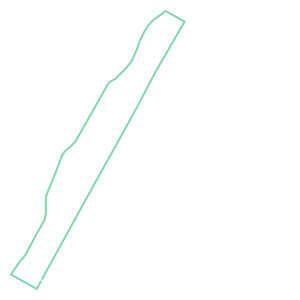

In [34]:
myRoute

And now we can calculate the length.

In [35]:
myRoute.length

16787.66006868951

Now let's build the array of distances at which we will create the points. Here we are setting the distance at which we will split the line and building the array.

In [36]:
distance_delta = 200
distances = np.arange(0, myRoute.length, distance_delta)

In [37]:
distances

array([    0.,   200.,   400.,   600.,   800.,  1000.,  1200.,  1400.,
        1600.,  1800.,  2000.,  2200.,  2400.,  2600.,  2800.,  3000.,
        3200.,  3400.,  3600.,  3800.,  4000.,  4200.,  4400.,  4600.,
        4800.,  5000.,  5200.,  5400.,  5600.,  5800.,  6000.,  6200.,
        6400.,  6600.,  6800.,  7000.,  7200.,  7400.,  7600.,  7800.,
        8000.,  8200.,  8400.,  8600.,  8800.,  9000.,  9200.,  9400.,
        9600.,  9800., 10000., 10200., 10400., 10600., 10800., 11000.,
       11200., 11400., 11600., 11800., 12000., 12200., 12400., 12600.,
       12800., 13000., 13200., 13400., 13600., 13800., 14000., 14200.,
       14400., 14600., 14800., 15000., 15200., 15400., 15600., 15800.,
       16000., 16200., 16400., 16600.])

Let's see how many points we will generate:

In [38]:
len(distances)

84

Finally, generating the points is easy. We use the `interpolate` distance to create them based on the array of distances.

In [39]:
points = [myRoute.interpolate(distance) for distance in distances]

In [40]:
# points

Let's print the first ten points to verify that what we got is ok.

In [41]:
for point in points[:10]:
    print(point.x, point.y)

994140.2119807308 233396.06117546154
994236.4532121198 233571.38266695853
994332.6944435087 233746.7041584555
994428.9356748977 233922.02564995253
994525.1769062867 234097.3471414495
994621.4181376757 234272.6686329465
994717.6593690647 234447.9901244435
994813.9006004537 234623.31161594047
994910.1418318427 234798.63310743746
995006.3830632317 234973.95459893448


Now let's put the points into a `GeoDataFrame` so that we can easily reproject them into the crs that the API uses

In [42]:
pointsAlongRoute = gpd.GeoDataFrame(data=None, geometry=points, crs='epsg:2263')

In [43]:
pointsAlongRoute.head(3)

,geometry
0,POINT (994140.212 233396.061)
1,POINT (994236.453 233571.383)
2,POINT (994332.694 233746.704)


In [44]:
pointsAlongRoute.dtypes

geometry    geometry
dtype: object

In [45]:
pointsAlongRoute.to_crs('epsg:4326', inplace=True)
route.to_crs('epsg:4326', inplace=True)

In [46]:
pointsAlongRoute.dtypes

geometry    geometry
dtype: object

And let's do a quick plot to make sure they are in the right place.

In [47]:
routeMap = alt.Chart(route).mark_geoshape(fill=None, stroke='black')
pointMap = alt.Chart(pointsAlongRoute).mark_geoshape(fill='red', stroke=None)
routeMap + pointMap

alt.LayerChart(...)

## Creating points from columns

In [48]:
df_co3.head(3)

,FILEID,STUSAB,GEOCODE,COUNTY,TRACT,BLKGRP,BLOCK,AREALAND,NAME,INTPTLAT,INTPTLON,P0010001,P0020001,P0030001,P0050001,P0050003,P0050004,GEOID20,county_name,TOTALPOP_ADJ,dif_pop,adjpop
96619,PLST,CO,80759664001238,75,966400,1,1238,631605,Block 1238,40.611755,-103.161651,2436,2436,2436,2436,2436,0,80759664001238,Logan,486,-1950,486
31481,PLST,CO,80259696012045,25,969601,2,2045,472181,Block 2045,38.158903,-103.956907,1776,1776,1776,1776,1776,0,80259696012045,Crowley,316,-1460,316
65257,PLST,CO,80439803001008,43,980300,1,1008,1717061,Block 1008,38.423025,-105.154641,1419,1419,1419,1419,1419,0,80439803001008,Fremont,106,-1313,106


In [49]:
df_co3['long'] = df_co3['INTPTLON']
df_co3['lat'] = df_co3['INTPTLAT']

In [50]:
df_co3.head(2)

,FILEID,STUSAB,GEOCODE,COUNTY,TRACT,BLKGRP,BLOCK,AREALAND,NAME,INTPTLAT,INTPTLON,P0010001,P0020001,P0030001,P0050001,P0050003,P0050004,GEOID20,county_name,TOTALPOP_ADJ,dif_pop,adjpop,long,lat
96619,PLST,CO,80759664001238,75,966400,1,1238,631605,Block 1238,40.611755,-103.161651,2436,2436,2436,2436,2436,0,80759664001238,Logan,486,-1950,486,-103.161651,40.611755
31481,PLST,CO,80259696012045,25,969601,2,2045,472181,Block 2045,38.158903,-103.956907,1776,1776,1776,1776,1776,0,80259696012045,Crowley,316,-1460,316,-103.956907,38.158903


In [51]:
df_co2['long'] = df_co2['INTPTLON']
df_co2['lat'] = df_co2['INTPTLAT']

In [52]:
df_co2.head(2)

,FILEID,STUSAB,GEOCODE,COUNTY,TRACT,BLKGRP,BLOCK,AREALAND,NAME,INTPTLAT,INTPTLON,P0010001,P0020001,P0030001,P0050001,P0050003,P0050004,GEOID20,county_name,TOTALPOP_ADJ,dif_pop,adjpop,long,lat
65245,PLST,CO,80439802001000,43,980200,1,1000,2173673,Block 1000,38.359615,-105.097914,2532,2532,2532,2532,2532,0,80439802001000,Fremont,2532,0,2532,-105.097914,38.359615
96619,PLST,CO,80759664001238,75,966400,1,1238,631605,Block 1238,40.611755,-103.161651,2436,2436,2436,2436,2436,0,80759664001238,Logan,486,-1950,486,-103.161651,40.611755


In [53]:
df_co2.dtypes

FILEID           object
STUSAB           object
GEOCODE           int64
COUNTY            int64
TRACT             int64
BLKGRP            int64
BLOCK             int64
AREALAND          int64
NAME             object
INTPTLAT        float64
INTPTLON        float64
P0010001          int64
P0020001          int64
P0030001          int64
P0050001          int64
P0050003          int64
P0050004          int64
GEOID20           int64
county_name      object
TOTALPOP_ADJ      int64
dif_pop           int64
adjpop            int64
long            float64
lat             float64
dtype: object

In [54]:
df_co2.columns

Index(['FILEID', 'STUSAB', 'GEOCODE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK',
       'AREALAND', 'NAME', 'INTPTLAT', 'INTPTLON', 'P0010001', 'P0020001',
       'P0030001', 'P0050001', 'P0050003', 'P0050004', 'GEOID20',
       'county_name', 'TOTALPOP_ADJ', 'dif_pop', 'adjpop', 'long', 'lat'],
      dtype='object')

In [55]:
# pointsAlongRoute = gpd.GeoDataFrame(data=None, geometry=points, crs='epsg:2232')

In [56]:
df_co3Geo = gpd.GeoDataFrame(data=df_co3, geometry=gpd.points_from_xy(x=df_co3['long'], y=df_co3['lat']), crs='epsg:2232')

In [57]:
df_co3Geo.head(2)

,FILEID,STUSAB,GEOCODE,COUNTY,TRACT,BLKGRP,BLOCK,AREALAND,NAME,INTPTLAT,INTPTLON,P0010001,P0020001,P0030001,P0050001,P0050003,P0050004,GEOID20,county_name,TOTALPOP_ADJ,dif_pop,adjpop,long,lat,geometry
96619,PLST,CO,80759664001238,75,966400,1,1238,631605,Block 1238,40.611755,-103.161651,2436,2436,2436,2436,2436,0,80759664001238,Logan,486,-1950,486,-103.161651,40.611755,POINT (-103.162 40.612)
31481,PLST,CO,80259696012045,25,969601,2,2045,472181,Block 2045,38.158903,-103.956907,1776,1776,1776,1776,1776,0,80259696012045,Crowley,316,-1460,316,-103.956907,38.158903,POINT (-103.957 38.159)


In [58]:
df_co3Geo.crs

<Projected CRS: EPSG:2232>
Name: NAD83 / Colorado Central (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Colorado - counties Arapahoe; Chaffee; Cheyenne; Clear Creek; Delta; Denver; Douglas; Eagle; El Paso; Elbert; Fremont; Garfield; Gunnison; Jefferson; Kit Carson; Lake; Lincoln; Mesa; Park; Pitkin; Summit; Teller.
- bounds: (-109.06, 38.14, -102.04, 40.09)
Coordinate Operation:
- name: SPCS83 Colorado Central zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [59]:
df_co3Geo.to_file('df_co3Geo.geojson', driver='GeoJSON')

In [60]:
df_co3Geo.to_file('input/df_co3Geo.geojson', driver='GeoJSON')

In [61]:
df_co2Geo = gpd.GeoDataFrame(data=df_co2, geometry=gpd.points_from_xy(x=df_co2['long'], y=df_co2['lat']), crs='epsg:2232')

In [62]:
df_co2Geo.head(3)

,FILEID,STUSAB,GEOCODE,COUNTY,TRACT,BLKGRP,BLOCK,AREALAND,NAME,INTPTLAT,INTPTLON,P0010001,P0020001,P0030001,P0050001,P0050003,P0050004,GEOID20,county_name,TOTALPOP_ADJ,dif_pop,adjpop,long,lat,geometry
65245,PLST,CO,80439802001000,43,980200,1,1000,2173673,Block 1000,38.359615,-105.097914,2532,2532,2532,2532,2532,0,80439802001000,Fremont,2532,0,2532,-105.097914,38.359615,POINT (-105.098 38.360)
96619,PLST,CO,80759664001238,75,966400,1,1238,631605,Block 1238,40.611755,-103.161651,2436,2436,2436,2436,2436,0,80759664001238,Logan,486,-1950,486,-103.161651,40.611755,POINT (-103.162 40.612)
31481,PLST,CO,80259696012045,25,969601,2,2045,472181,Block 2045,38.158903,-103.956907,1776,1776,1776,1776,1776,0,80259696012045,Crowley,316,-1460,316,-103.956907,38.158903,POINT (-103.957 38.159)


In [63]:
df_co2Geo.crs

<Projected CRS: EPSG:2232>
Name: NAD83 / Colorado Central (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Colorado - counties Arapahoe; Chaffee; Cheyenne; Clear Creek; Delta; Denver; Douglas; Eagle; El Paso; Elbert; Fremont; Garfield; Gunnison; Jefferson; Kit Carson; Lake; Lincoln; Mesa; Park; Pitkin; Summit; Teller.
- bounds: (-109.06, 38.14, -102.04, 40.09)
Coordinate Operation:
- name: SPCS83 Colorado Central zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

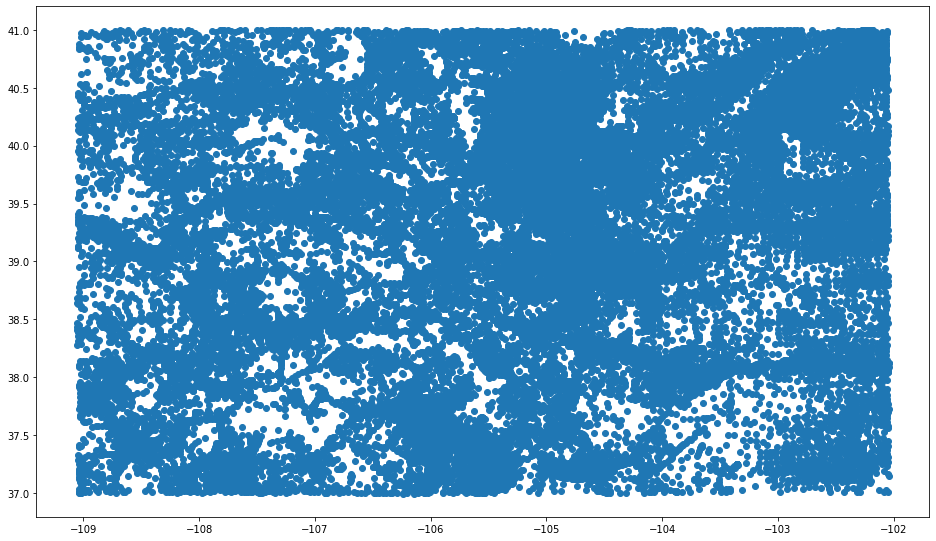

In [64]:
df_co2Geo.plot()

In [65]:
df_co2Geo.to_file('df_co2Geo.geojson', driver='GeoJSON')

In [66]:
df_co2Geo.to_file('input/df_co2Geo.geojson', driver='GeoJSON')

In [67]:
points = gpd.read_file('input/df_co3Geo.geojson')

In [68]:
points.crs

<Projected CRS: EPSG:2232>
Name: NAD83 / Colorado Central (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Colorado - counties Arapahoe; Chaffee; Cheyenne; Clear Creek; Delta; Denver; Douglas; Eagle; El Paso; Elbert; Fremont; Garfield; Gunnison; Jefferson; Kit Carson; Lake; Lincoln; Mesa; Park; Pitkin; Summit; Teller.
- bounds: (-109.06, 38.14, -102.04, 40.09)
Coordinate Operation:
- name: SPCS83 Colorado Central zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [69]:
points.head(2)

,FILEID,STUSAB,GEOCODE,COUNTY,TRACT,BLKGRP,BLOCK,AREALAND,NAME,INTPTLAT,INTPTLON,P0010001,P0020001,P0030001,P0050001,P0050003,P0050004,GEOID20,county_name,TOTALPOP_ADJ,dif_pop,adjpop,long,lat,geometry
0,PLST,CO,80759664001238,75,966400,1,1238,631605,Block 1238,40.611755,-103.161651,2436,2436,2436,2436,2436,0,80759664001238,Logan,486,-1950,486,-103.161651,40.611755,POINT (-103.162 40.612)
1,PLST,CO,80259696012045,25,969601,2,2045,472181,Block 2045,38.158903,-103.956907,1776,1776,1776,1776,1776,0,80259696012045,Crowley,316,-1460,316,-103.956907,38.158903,POINT (-103.957 38.159)


In [70]:
# points.dtypes

In [71]:
df_co3_points = df_co3Geo['geometry'] 
df_co3_points.head(2)

96619    POINT (-103.162 40.612)
31481    POINT (-103.957 38.159)
Name: geometry, dtype: geometry

#### Converting a GeoSeries to a GeoDataFrame with Geopandas

In [72]:
points2 = gpd.GeoDataFrame(gpd.GeoSeries(df_co3_points))

In [73]:
# df_co2_points.to_crs('epsg:2232', inplace=True)

In [74]:
# pointMap2 = alt.Chart(points2).mark_geoshape(fill='red', stroke=None)
# pointMap2

## Querying the API with the Points

First, we define the function that will query the API.

In [75]:
def queryGoogleStreetView(size, lat, lon, heading, fov, pitch, apiKey, outputFile):
    baseURL = 'https://maps.googleapis.com/maps/api/streetview?'
    location = lat + ',' + lon
    outputFileName = outputFile
    request = baseURL + 'size=' + size + '&location=' + location + '&heading=' + str(heading) + '&fov=' + str(fov) + '&pitch=' + str(pitch) + '&key=' + apiKey
    response = requests.get(request)
    if response.status_code == 200:
        with open("output/" + outputFileName, 'wb') as f:
            f.write(response.content)
    print('Retrieved Google Street View image...')

Next, we set up the base parameters. Note that in the function above we stripped the URL from all the extra parameters and we will pass them on when we call the function.

In [76]:
headings = [0,90,180,270]
size = '640x640'
fov = 120
pitch = 0

Finally, let's iterate over the points dataframe and query the API for ever point.

In [77]:
pointsAlongRoute.head(2)

,geometry
0,POINT (-73.96427 40.80729)
1,POINT (-73.96393 40.80777)


In [78]:
pointsAlongRoute.dtypes

geometry    geometry
dtype: object

In [79]:
# for index, row in pointsAlongRoute.iterrows():
#     lat = str(row[0].y)
#     lon = str(row[0].x)
#     for angle in headings:
#         outputFile = 'Img{0}_{1}.png'.format(str(index).zfill(3),angle)
#         queryGoogleStreetView(size, lat, lon, angle, fov, pitch, apikey, outputFile)
#     sleep(1)

In [80]:
df_co3_points.head(2)

96619    POINT (-103.162 40.612)
31481    POINT (-103.957 38.159)
Name: geometry, dtype: geometry

In [81]:
df_co3_points.dtypes

In [82]:
df_co3_points.head(2)

96619    POINT (-103.162 40.612)
31481    POINT (-103.957 38.159)
Name: geometry, dtype: geometry

In [83]:
points2.dtypes

geometry    geometry
dtype: object

In [84]:
# for index, row in points2.iterrows():
#     lat = str(row[0].y)
#     lon = str(row[0].x)
#     for angle in headings:
#         outputFile = 'Img{0}_{1}.png'.format(str(index).zfill(3),angle)
#         queryGoogleStreetView(size, lat, lon, angle, fov, pitch, apikey, outputFile)
#     sleep(1)

### Looking for places near lat longs

https://towardsdatascience.com/how-to-use-the-google-places-api-for-location-analysis-and-more-17e48f8f25b1



In [85]:
# https://maps.googleapis.com/maps/api/place/textsearch/output_type?query=your_query&location=latitude,longitude&radius=number_of_meters&region=region_code&type=establishment_type&key=YOUR_API_KEY

In [86]:
# "https://maps.googleapis.com/maps/api/place/textsearch/json?query=coffee+shop&location=35.792491,-78.653009&radius=2000&region=us&type=cafe,bakery&key=apikey"

In [87]:
# import requests
# import json
# import time
# prisons = []
# params = {}
  
# endpoint_url = "https://maps.googleapis.com/maps/api/place/textsearch/json?query=coffee+shop&location=35.7790905,-78.642413&radius=2000&region=us&type=cafe,bakery&key=MY_API_KEY"
         
# res = requests.get(endpoint_url, params = params)
# results =  json.loads(res.content)
# coffee_shops.extend(results['results'])
# time.sleep(2)
# while "next_page_token" in results:
#      params['pagetoken'] = results['next_page_token'],
#      res = requests.get(endpoint_url, params = params)
#      results = json.loads(res.content)
#      prisons.extend(results['results'])
#      time.sleep(2)

#### Using Static Maps API to search for facilities near GPS Coordinates of Prisons

In [93]:
# example URL
# https://maps.googleapis.com/maps/api/staticmap?center=40.714728,-73.998672&zoom=12&size=400x400&maptype=hybrid&key=YOUR_API_KEY
# &signature=YOUR_SIGNATURE

In [94]:
def queryMapsStatic(size, lat, lon, zoom, maptype, apiKey, outputFile):
    baseURL = 'https://maps.googleapis.com/maps/api/staticmap?'
    location = lat + ',' + lon
    outputFileName = outputFile
    request = baseURL + 'center=' + location + '&zoom=' + zoom + '&size=' + size + '&maptype=' + maptype + '&key=' + apiKey
    response = requests.get(request)
    if response.status_code == 200:
        with open("output/" + outputFileName, 'wb') as f:
            f.write(response.content)
    print('Retrieved Google Static Map...')

In [95]:
headings2 = [90]
size = '1000x640'
zoom = '16'
maptype = 'hybrid'

In [98]:
for index, row in points2.iloc[:10].iterrows():
    lat = str(row[0].y)
    lon = str(row[0].x)
    for angle in headings2:
      outputFile = 'Img{0}_{1}.png'.format(str(index).zfill(3),angle)
      queryMapsStatic(size, lat, lon, zoom, maptype, apikey, outputFile)
    sleep(1)

Retrieved Google Static Map...
Retrieved Google Static Map...
Retrieved Google Static Map...
Retrieved Google Static Map...
Retrieved Google Static Map...
Retrieved Google Static Map...
Retrieved Google Static Map...
Retrieved Google Static Map...
Retrieved Google Static Map...
Retrieved Google Static Map...


In [99]:
points2.head(10)

,geometry
96619,POINT (-103.162 40.612)
31481,POINT (-103.957 38.159)
65257,POINT (-105.155 38.423)
18716,POINT (-103.197 38.064)
27389,POINT (-106.119 38.817)
31548,POINT (-103.841 38.193)
39278,POINT (-104.862 39.765)
65243,POINT (-105.249 38.438)
94493,POINT (-103.691 39.219)
65254,POINT (-105.158 38.441)


In [100]:
df_co3Geo.head(10)

,FILEID,STUSAB,GEOCODE,COUNTY,TRACT,BLKGRP,BLOCK,AREALAND,NAME,INTPTLAT,INTPTLON,P0010001,P0020001,P0030001,P0050001,P0050003,P0050004,GEOID20,county_name,TOTALPOP_ADJ,dif_pop,adjpop,long,lat,geometry
96619,PLST,CO,80759664001238,75,966400,1,1238,631605,Block 1238,40.611755,-103.161651,2436,2436,2436,2436,2436,0,80759664001238,Logan,486,-1950,486,-103.161651,40.611755,POINT (-103.162 40.612)
31481,PLST,CO,80259696012045,25,969601,2,2045,472181,Block 2045,38.158903,-103.956907,1776,1776,1776,1776,1776,0,80259696012045,Crowley,316,-1460,316,-103.956907,38.158903,POINT (-103.957 38.159)
65257,PLST,CO,80439803001008,43,980300,1,1008,1717061,Block 1008,38.423025,-105.154641,1419,1419,1419,1419,1419,0,80439803001008,Fremont,106,-1313,106,-105.154641,38.423025,POINT (-105.155 38.423)
18716,PLST,CO,80119667011031,11,966701,1,1031,502018,Block 1031,38.064394,-103.197027,1224,1224,1212,1202,1202,0,80119667011031,Bent,73,-1151,73,-103.197027,38.064394,POINT (-103.197 38.064)
27389,PLST,CO,80150004021064,15,402,1,1064,212354,Block 1064,38.817104,-106.118779,1190,1190,1190,1190,1190,0,80150004021064,Chaffee,188,-1002,188,-106.118779,38.817104,POINT (-106.119 38.817)
31548,PLST,CO,80259696021050,25,969602,1,1050,403370,Block 1050,38.192536,-103.841322,1063,1063,1063,1063,1063,0,80259696021050,Crowley,201,-862,201,-103.841322,38.192536,POINT (-103.841 38.193)
39278,PLST,CO,80310041101002,31,4110,1,1002,145098,Block 1002,39.765165,-104.861804,938,938,938,938,938,0,80310041101002,Denver,170,-768,170,-104.861804,39.765165,POINT (-104.862 39.765)
65243,PLST,CO,80439801001002,43,980100,1,1002,109012,Block 1002,38.437664,-105.248566,564,564,564,564,564,0,80439801001002,Fremont,-165,-729,-165,-105.248566,38.437664,POINT (-105.249 38.438)
94493,PLST,CO,80739617002061,73,961700,2,2061,634376,Block 2061,39.218744,-103.691289,904,904,904,904,904,0,80739617002061,Lincoln,182,-722,182,-103.691289,39.218744,POINT (-103.691 39.219)
65254,PLST,CO,80439803001005,43,980300,1,1005,100077,Block 1005,38.440661,-105.157668,705,705,705,705,705,0,80439803001005,Fremont,149,-556,149,-105.157668,38.440661,POINT (-105.158 38.441)


## Downloading all the files

Let's create a zip file with all the images so we can download them all at once.

In [101]:
!zip -r /content/output/outputImages.zip /content/output/Img*

updating: content/output/Img18716_0.png (deflated 0%)
updating: content/output/Img27389_0.png (deflated 0%)
updating: content/output/Img31481_0.png (deflated 0%)
updating: content/output/Img31548_0.png (deflated 0%)
updating: content/output/Img39278_0.png (deflated 0%)
updating: content/output/Img65243_0.png (deflated 0%)
updating: content/output/Img65254_0.png (deflated 0%)
updating: content/output/Img65257_0.png (deflated 0%)
updating: content/output/Img94493_0.png (deflated 0%)
updating: content/output/Img96619_0.png (deflated 0%)
updating: content/output/Img18716_90.png (deflated 0%)
updating: content/output/Img27389_90.png (deflated 0%)
updating: content/output/Img31481_90.png (deflated 0%)
updating: content/output/Img31548_90.png (deflated 0%)
updating: content/output/Img39278_90.png (deflated 0%)
updating: content/output/Img65243_90.png (deflated 0%)
updating: content/output/Img65254_90.png (deflated 0%)
updating: content/output/Img65257_90.png (deflated 0%)
updating: content/ou